In [ ]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

Learning_Rate=1e-5
width=height=900 # image width and height
batchSize=3

TrainFolder="../data/fretboard_dataset/fretboard_frames_train/"
fn_list=os.listdir(TrainFolder) # Create list of images
ListImages = []
for fn in fn_list:
    if not "annotated" in fn:
        ListImages.append(fn)

#----------------------------------------------Transform image-------------------------------------------------------------------
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])
#---------------------Read image ---------------------------------------------------------
def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, ListImages[idx]))[:,:,0:3]
    Fretboard =  cv2.imread(os.path.join(TrainFolder, f"annotated_{ListImages[idx]}"),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Fretboard is not None:  AnnMap[ Fretboard  == 1 ] = 1
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)
    return Img,AnnMap
#--------------Load batch of images-----------------------------------------------------
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    return images, ann
#--------------Load and set net and optimizer-------------------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer
#----------------Train--------------------------------------------------------------------------
for itr in range(10000): # Training loop
   images,ann=LoadBatch() # Load taining batch
   images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
   ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
   print(itr,") Loss=",Loss.data.cpu().numpy())
   if itr % 100 == 0: #Save model weight every once in a while
        print("Saving Model " +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")

In [ ]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
modelPath = "70.torch"  # Path to trained model
imagePath = "../data/fretboard_dataset/fretboard_frames_test/28_1.png"  # Test image
height=width=900
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), 
                           tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])  # tf.Resize((300,600)),tf.RandomRotation(145)])#

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)
Net = torchvision.models.segmentation.deeplabv3_resnet50(weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 2 classes
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath)) # Load trained model
Net.eval() # Set to evaluation mode
Img = cv2.imread(imagePath) # load test image
height_orgin , widh_orgin ,d = Img.shape # Get image original size 
plt.imshow(Img[:,:,::-1])  # Show image
plt.show()
Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin,widh_orgin), antialias=True)(Prd[0]) # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
plt.imshow(seg)  # display image
plt.show()

### Mobile net

In [10]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

Learning_Rate=1e-5
width=height=900 # image width and height
batchSize=3

TrainFolder="../data/fretboard_dataset/fretboard_frames_train/"
fn_list=os.listdir(TrainFolder) # Create list of images
ListImages = []
for fn in fn_list:
    if not "annotated" in fn:
        ListImages.append(fn)

#----------------------------------------------Transform image-------------------------------------------------------------------
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])
#---------------------Read image ---------------------------------------------------------
def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, ListImages[idx]))[:,:,0:3]
    Fretboard =  cv2.imread(os.path.join(TrainFolder, f"annotated_{ListImages[idx]}"),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Fretboard is not None:  AnnMap[ Fretboard  == 1 ] = 1
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)
    return Img,AnnMap
#--------------Load batch of images-----------------------------------------------------
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    return images, ann
#--------------Load and set net and optimizer-------------------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights=torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT) # Load net
Net.classifier.low_classifier = torch.nn.Conv2d(40, 2, kernel_size=(1, 1), stride=(1, 1)) # Change classifier layers
Net.classifier.high_classifier = torch.nn.Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer
#----------------Train--------------------------------------------------------------------------
for itr in range(1000): # Training loop
   images,ann=LoadBatch() # Load taining batch
   images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
   ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
   print(itr,") Loss=",Loss.data.cpu().numpy())
   if itr % 100 == 0: #Save model weight every once in a while
        print("Saving Model " +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")

0 ) Loss= 0.7121847
Saving Model 0.torch
1 ) Loss= 0.7083323
2 ) Loss= 0.70759183
3 ) Loss= 0.70323235
4 ) Loss= 0.6994598
5 ) Loss= 0.6959737
6 ) Loss= 0.6907527
7 ) Loss= 0.68808806
8 ) Loss= 0.6850134
9 ) Loss= 0.6832278
10 ) Loss= 0.6797125
11 ) Loss= 0.6766
12 ) Loss= 0.6737443
13 ) Loss= 0.6720577
14 ) Loss= 0.6658378
15 ) Loss= 0.6636921
16 ) Loss= 0.66155255
17 ) Loss= 0.6590918
18 ) Loss= 0.6559475
19 ) Loss= 0.65286064
20 ) Loss= 0.6500735
21 ) Loss= 0.64746296
22 ) Loss= 0.64361465
23 ) Loss= 0.64076287
24 ) Loss= 0.63936996
25 ) Loss= 0.6347255
26 ) Loss= 0.6334318
27 ) Loss= 0.6319534
28 ) Loss= 0.6303865
29 ) Loss= 0.6274328
30 ) Loss= 0.62418485
31 ) Loss= 0.61874765
32 ) Loss= 0.61961913
33 ) Loss= 0.6131332
34 ) Loss= 0.611961
35 ) Loss= 0.6080234
36 ) Loss= 0.6066156
37 ) Loss= 0.6065939
38 ) Loss= 0.6021568
39 ) Loss= 0.6008476
40 ) Loss= 0.59954107
41 ) Loss= 0.59579664
42 ) Loss= 0.59178007
43 ) Loss= 0.59063584
44 ) Loss= 0.5864776
45 ) Loss= 0.584318
46 ) Loss= 0

KeyboardInterrupt: 

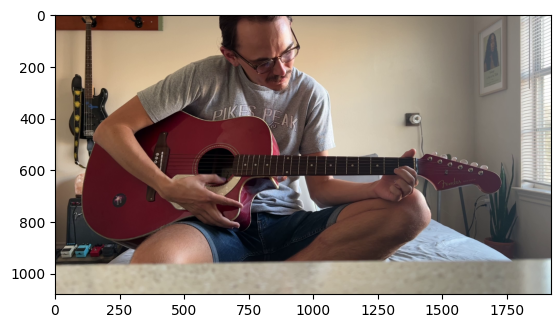

0


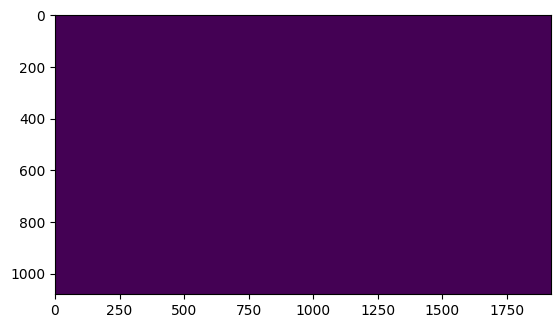

In [17]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
modelPath = "../data/700.torch"  # Path to trained model
imagePath = "../data/fretboard_dataset/fretboard_frames_test/28_3.png"  # Test image
height=width=900
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), 
                           tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])  # tf.Resize((300,600)),tf.RandomRotation(145)])#

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)
Net = torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights=torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT) # Load net
Net.classifier.low_classifier = torch.nn.Conv2d(40, 2, kernel_size=(1, 1), stride=(1, 1)) # Change classifier layers
Net.classifier.high_classifier = torch.nn.Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath)) # Load trained model
Net.eval() # Set to evaluation mode
Img = cv2.imread(imagePath) # load test image
height_orgin , widh_orgin ,d = Img.shape # Get image original size 
plt.imshow(Img[:,:,::-1])  # Show image
plt.show()
Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin,widh_orgin), antialias=True)(Prd[0]) # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
plt.imshow(seg)  # display image
plt.show()